![avatar](figures/HOG_visual.png)

# SI100B Assignment 3 (Fall, 2021): 
# Appearance-based Gaze Estimation
*******
## Bonus Section: HOG with numpy
<br/>

Author: `Yintao Xu` | Modified by: `Yucong Chen`, `Yiwen Wu` | Proofread by: `Ziqi Gao`

Email: `{xuyt, chenyc, wuyw1, gaozq}@shanghaitech.edu.cn` | Update: `2021-11` 
<br/><br/>

Make sure you have pass the section1&2 before starting this bonus part.

In [3]:
# IMPORTANT: run this cell before runnng any cell to activate auto re-import
%load_ext autoreload
%autoreload 2

# 'gazelib' is the toolkit provided by this assignment, at the same directory of this notebook
from gazelib.utils import *
import numpy as np
import time
import matplotlib.pyplot as plt
import random

plt.style.use("fivethirtyeight")
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# load the training dataset
train_df = load_train_csv_as_df()
# **DO NOT MAKE ANY CHANGE TO IT THROUGHOUT THE NOTEBOOK**

# previwe the first 10 samples
train_df.head(10)

,subject_id,yaw,pitch,image_base64
0,5,-0.202976,-0.300898,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
1,5,0.153875,-0.216009,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
2,6,-0.240222,-0.231348,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
3,6,0.082681,-0.148303,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
4,11,0.141780,-0.259967,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
5,14,0.089140,-0.223431,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
6,6,-0.052793,-0.056385,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
7,13,-0.275569,-0.115087,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
8,5,0.095293,-0.210037,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...
9,2,-0.066253,-0.250547,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBw...


In [8]:
# transform data into numpy arrays
def df2nptensor(df):
    imgs = []
    imgs_HOG = []
    gaze_dirs = []

    print_interval = 1000
    print_cnter = 0
    
    for _, i in df.iterrows():
        if print_cnter % print_interval == 0:
            print("[{} / {}]".format(print_cnter, len(df)), end='\r')
        print_cnter += 1
        im_arr = decode_base64_img(i['image_base64'])
        gaze_dirs.append([i['yaw'], i['pitch']])
        im = im_arr / 255
        
        imgs.append(im)
    
    gaze_dirs = np.array(gaze_dirs)
    imgs = np.array(imgs)
    
    return gaze_dirs, imgs

# For effciency, we only takes first 5,000 samples. Pick subject 5 as validation 
# set and the rest of the dataset as training set
SAMPLE_NUM = 5000
print("Start to generate sampled dataset, it may take ~10s.")
train_Y, train_X = df2nptensor(train_df[train_df["subject_id"] != 5][: int(SAMPLE_NUM * 0.8)])
val_Y, val_X = df2nptensor(train_df[train_df["subject_id"] == 5][: int(SAMPLE_NUM * 0.2)])

print("train_X.shape: {}".format(train_X.shape))
print("train_Y.shape: {}".format(train_Y.shape))
print("val_X.shape: {}".format(val_X.shape))
print("val_X.shape: {}".format(val_Y.shape))

Start to generate sampled dataset, it may take ~10s.
train_X.shape: (4000, 18, 30)
train_Y.shape: (4000, 2)
val_X.shape: (1000, 18, 30)
val_X.shape: (1000, 2)


### Roadmap

At previous sections, an estimation pipeline for gaze vector has been built:

<img src="figures/gaze_model_pipeline.png" style="zoom:80%" />

Formalize the input/ouput of our estimation pipeline mathematically:
- `Input`: the gray-scale image $I\in \mathbb{R}^{18\times30}$ (18x30 numpy array)
- `Output`: two floats: yaw($\gamma \in \mathbb{R}$), pitch($\theta  \in \mathbb{R}$)


In previous sections, we evaluated the simlarity between image by euclidean distance. However, naive computation over the whole images is computationally expensive.

## Bonus-1: 2D Convolution[1] (10 points)
Kernel is an important operator in image processing, which is used for blurring, sharpening, edge detection, etc. This is accomplished by doing a convolution between the kernel and an image. 

Convolution is the process of transforming an image by applying a kernel over each pixel and its local neighbors across the entire image. The kernel is a matrix of values whose size and values determine the transformation effect of the convolution process. 


The demo below shows how a typical 2D convolution works: you start with a kernel $\textbf{F}$, the 3x3 moving square on the left, while the smaller numbers on the right-down corners are its weights. This kernel slides over the 2D input $\textbf{I}$, the blue 5x5 square, performs an element-wise multiplication with the corresponding pixel it is over, and then sums the resultingmultiplied values and returns the resulting value as the new value of the center pixel before sliding to the next position. The green 3x3 square is the output $\textbf{O}$ for this operation. 

![ChessUrl](figures/conv2d.gif) 

Formally, it is denoted as $*$:

$$
    \textbf{O} = \textbf{F} * \textbf{I}
$$

with $\textbf{O}$ corresponding to output, $\textbf{F}\in \mathbb{R}^{2K+1\times2K+1}$ corresponding to filter kernel, $\textbf{I}\in \mathbb{R}^{W \times H}$ corresponding to the input Image.

The formula can be written as follows:

$$
    \textbf{O}_{i,j} = \sum_{k=0}^{2K} \sum_{l=0}^{2K} \textbf{F}_{k,l} \times \textbf{I}_{k + i, l + j}, i \in [0, W -2], j \in [0, H - 2]
$$

For instance, for the upper-left corner of output value 12 at previous figure:

$$
    12 = 3 \times 0 + 3 \times 1 + 2 \times 2 + 0 \times 2 + 0 \times 2 + 1 \times 0 + 3 \times 0 + 1 \times 1 + 2 \times 2
$$


![](figures/code_time.png)

**Complete code at `AppearanceGazeEst/conv2d3x3`**

In [11]:
# Local Test - Bonus-1
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import conv2d3x3
from gazelib.task_2_judge import assert_eq_np

img = np.array([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1],
    [3, 1, 2, 2, 3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]
])
kernel = np.array([
    [0, 1, 2],
    [2, 2, 0],
    [0, 1, 2]
])
gt_out = np.array([
    [12, 12, 17],
    [10, 17, 19],
    [9, 6, 14]
])

out = conv2d3x3(img, kernel)
assert_eq_np(gt_out, out)

print("Pass Bonus-1 - convolution 2d local test.")

Pass Bonus-1 - convolution 2d local test.


### Gradient of An Image [2]

Gradient of an image is a directional change in the intensity or color in the image. 

There is a widely accepted assumption in computer vision community: 
> local object appearance and shape can often be characterized rather well by **the distribution of local intensity gradients or edge directions**, even without precise knowledge of the corresponding gradient or edge positions.

Therefore, studying the **image gradient**[3] is important. 

![](figures/HOG.png)

Mathematically, the gradient of a two-variable function (here the image intensity function) at each image point is a 2D vector with the components given by the derivatives in the horizontal and vertical directions.

An image in modern devices can be viewed as a matrix of pixel intensity whose distribution is discrete. However, derivatives of this function cannot be defined unless we assume that there is an underlying continuous intensity function which has been sampled at the image points. 

The most common way to approximate the image gradient is to **convolve an image with a kernel**, such as the [**Sobel operator**](https://en.wikipedia.org/wiki/Sobel_operator), which is built on the **2D convolution** you've done above.

## Bonus-2: Compute Gradient By Sobel Operator - Apply convolution by numpy [4] (10 points)
The Sobel operator is a discrete differentiation operator, which can be used to compute an approximation of the gradient of the image intensity function.

The operator uses two 3×3 kernels which are convolved with the original image to calculate approximations of the derivatives – one for horizontal changes, and one for vertical. The 2D convolution has been implemented by the previous section. If we define $\textbf{I}$ as the source image, and $\textbf{Gx}$ and $\textbf{Gy}$ are two images, each of whose point contains the vertical and horizontal derivative approximations respectively. The computations are as follows:

$$
\mathbf {G} _{x}={\begin{bmatrix}-1&0&1\\-2&0&2\\-1&0&1\end{bmatrix}}*\mathbf {I} \quad {\mbox{and}}\quad \mathbf {G} _{y}={\begin{bmatrix}-1&-2&-1\\0&0&0\\1&2&1\end{bmatrix}}*\mathbf {I}
$$

In most implementations, they also apply a gaussian kernel to smooth the image before getting gradients.

![](figures/eye_grad_new.png)

Formally, for each pixel
$$
Mag = \sqrt{g _{x}^2 + g_{y}^2}
$$
$$
\mathbf{Dir} = [g _{x}; g_{y}]
$$
$$
\mathbf{Dir}_{norm} = \mathbf{Dir} / (Mag + 10^{-3})
$$
Here, $10^{-3}$ is applied to improve numerical robustness in case of zero magnitude.

![](figures/code_time.png)

**Complete the code of the sobel gradient computation at `AppearanceGazeEst.py/compute_grad`**

In [12]:
# Local Test - Bonus-2
# Note: feel free to print out your result to debug at gazelib.task_2_judge.py/assert_eq_2223
# if it cannot pass assert_eq_np
from AppearanceGazeEst import compute_grad
from gazelib.task_2_judge import assert_eq_2223

sanity_im = np.array([
    [1., 1., 7.], 
    [2., 1., 8.], 
    [3., 5., 2.]
])

grad_dir, grad_mag = compute_grad(sanity_im)
assert_eq_2223(grad_dir, grad_mag)
print("You pass the local test - Bonus-2")

You pass the local test - Bonus-2


#### *Now, playground!*

- Run the following cell repeatedly and see what you get.

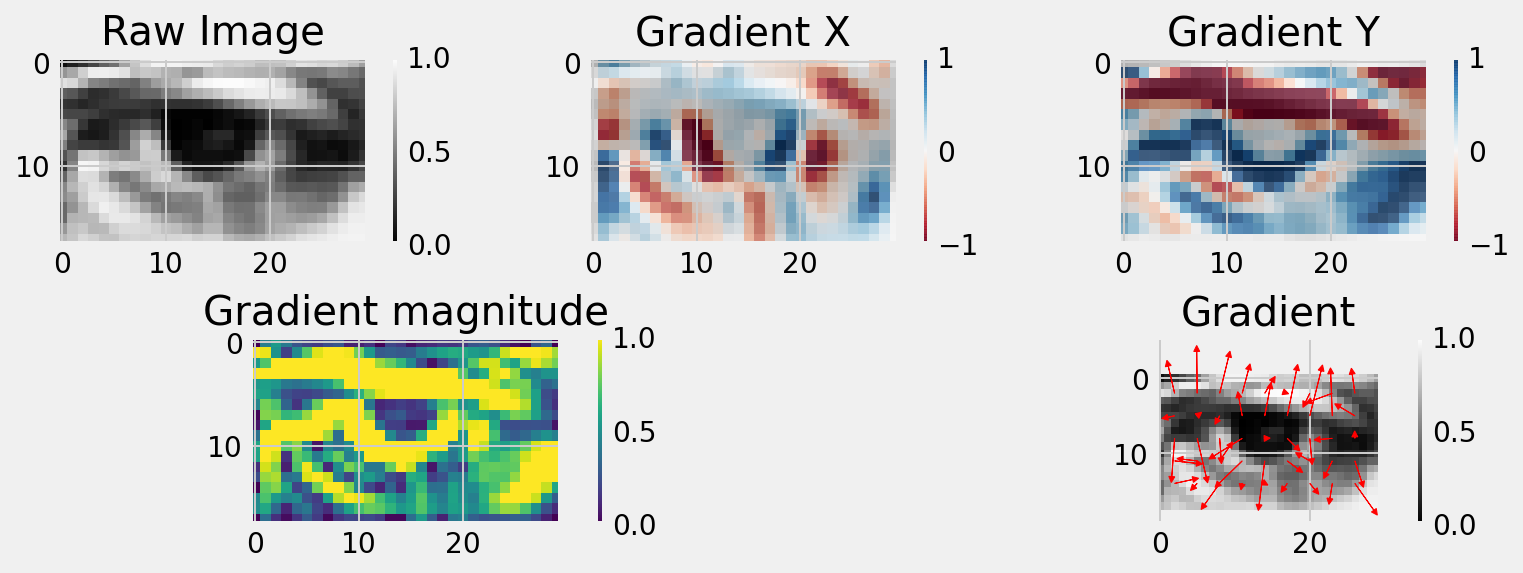

In [6]:
# sample an image to visualize the gradient computation
sample_im = train_X[random.randint(0, train_X.shape[0])]
gaze_dir, gaze_mag = compute_grad(sample_im)
vis.vis_grad(sample_im, gaze_dir[0] * gaze_mag, gaze_dir[1] * gaze_mag)

### Histogram of oriented gradient (HOG)
Recall that
> local object appearance and shape can often be characterized rather well by **the distribution of local intensity gradients or edge directions**, even without precise knowledge of the corresponding gradient or edge positions.

When finishing computing gradients, in the next step, you should get its distribution over an image (or an image patch). Using histogram is an intuitive way to model a distribution with many weighted data points(gradients of pixels, with direction and magnitude). This step is called **Orientation Binning**.

### Motivation: Why HOG? 


We have 42,000 images in our pandas data frame. Assume that in each estimation, we should do one floating number multplication for each pixels in every image.
<br/><br/>

#### *Now, playground!*
- Run the following cell repeatedly and see what you get.

In [13]:
a = np.random.randn(42000 * 18 * 30,)
b = np.random.randn(42000 * 18 * 30,)

time_start = time.time()
c = a * b
time_end = time.time()

print("Multiply 42000 * 18 * 30 numbers cost: {:.4f}s".format(time_end - time_start))

Multiply 42000 * 18 * 30 numbers cost: 0.0800s


**Large computational cost**

It runs ~0.06 seconds on *Intel(R) Core(TM) i7-6700 CPU @ 3.40GHz*, which sounds tractable. However, you may repeat 10,000 ~ 20,000 such operation, which means roughly that it will cost ~ 20 min. Besides, memory cost is also considerable. Therefore, we require a **dimension reduction** method to reduce the computation. 
<br/><br/>
**Not robust to translation**

If we apply euclidean distance to images, when a slight translation of image occurs, it may lead to dramatic change to output.

In computer vision community, **HOG** is a frequently used method to do the feature engineering of images with tractable size of dimension and more robustness.

### Details of Orientation Binning

**Note**: You are not required to go to very details of Orientation Binning. We'll provide you with a reference code.

<img src="figures/hist_grad_vis.png_fix.png" style="zoom:60%" />

**Range of angle**[6] 

In this assignment, angles are derived from `np.arctan2` towards gradient direction(x1,x2), which means that it ranges from $[-\pi, +\pi]$.

![](figures/arctan2_wiki.png)

**Bilinear voting policy**[5] 

A bin is selected based on the direction, and the vote (the value that goes into the bin) is selected based on the magnitude. 

Let’s first focus on the pixel encircled in blue. It has an angle (direction) of 30 degrees and magnitude of 5. So it adds 5 to the 30-deg. bin. The gradient at the pixel encircled using red has an angle of -40 degrees and magnitude of 3. Since -40 lies in $[-60,-30]$, the vote by the pixel splits into the two bins proportional to 1/dist. to the bin, i.e.1 for -60 and 2 for -30. 

**Boundary condtion** 

When an angle goes to boundary, for example, 160 degree, it should be goes to bin of 150-deg and -180-deg. However, due to the range of `np.arctan2`, angle skips numerically at 180 and -180 but adajacent at cartesian coordination.

## Bonus-3 Re-implement HOG - learn vectorization at numpy (10 points)

### Numpy: vectorization [7]

Vectorization is used to speed up the Python code without using loop. Numpy will invokes C-code directly at backend, which is more rapid than python loops.
<br/><br/>

#### *Now, playground!*
- Run the following cell repeatedly and see what you get.

In [18]:
size = int(1e7)
# Try this cell to see the power of vectorization
a = np.random.randn(size,)
b = np.random.randn(size,)

c = 0
# python loops
time_start = time.time()
for i in range(size):
    c = a[i] + b[i]
time_nonvec = time.time() - time_start

# vectorization
time_start = time.time()
c_ = np.sum(a + b)
time_vec = time.time() - time_start

speed_up_per = (time_nonvec / time_vec - 1) * 100

print("Before vectorization: {:.3f} s".format(time_nonvec))
print("After vectorization: {:.3f} s".format(time_vec))
print("Speedup: {:.2f}%".format(speed_up_per))

Before vectorization: 4.798 s
After vectorization: 0.050 s
Speedup: 9501.02%


![](figures/code_time.png)

**Complete the code of the HOG computation at `AppearanceGazeEst.py/bilinear_HOG`**

**Note**: the non-vectorized version is at `ApperanceGazeEstV2/bilinear_HOG_nonvec` above the target function `bilinear_HOG`. Please gaurantee that your implementation shares the same output as the non-vectorized version and speeds up at least 200%. On the autolab, you'll get a full grade if it speeds up over 100%.

In [82]:
# Local Test - Bonus-3
# Note: feel free to print out your result to debug at gazelib.task_2_judge.py/assert_eq_2223
# if it cannot pass assert_eq_np
from gazelib.HOG import bilinear_HOG_patch_nonvec
from AppearanceGazeEst import bilinear_HOG
import time

sample_im = train_X[5]
grad_dir, grad_mag = compute_grad(sample_im)
time_nonvec = 0
time_vec = 0
exp_num = 12

for _ in range(exp_num): # repeat experiments due to randomness of OS scheduling
    time_start = time.time()
    a = bilinear_HOG_patch_nonvec(gaze_dir, gaze_mag)
    time_nonvec += time.time() - time_start

    time_start = time.time()
    b = bilinear_HOG(gaze_dir, gaze_mag)
    time_vec += time.time() - time_start

speed_up_per = (time_nonvec / time_vec - 1) * 100

print('time_nonvec=',time_nonvec);print('time_vec=',time_vec);print("speed_up_per=",speed_up_per)

assert_eq_np(a, b)
assert speed_up_per > 200

print("Before vectorization(avg): {:.4f} s".format(time_nonvec / exp_num))
print("After vectorization(avg): {:.4f} s".format(time_vec / exp_num))
print("Speedup: {:.2f}%".format(speed_up_per))
print("You pass the local test - Bonus-3")

time_nonvec= 0.03492140769958496
time_vec= 0.0009953975677490234
speed_up_per= 3408.2874251497005
Before vectorization(avg): 0.0029 s
After vectorization(avg): 0.0001 s
Speedup: 3408.29%
You pass the local test - Bonus-3


#### *Now, playground!*

- Run the following cell repeatedly and see what you get.

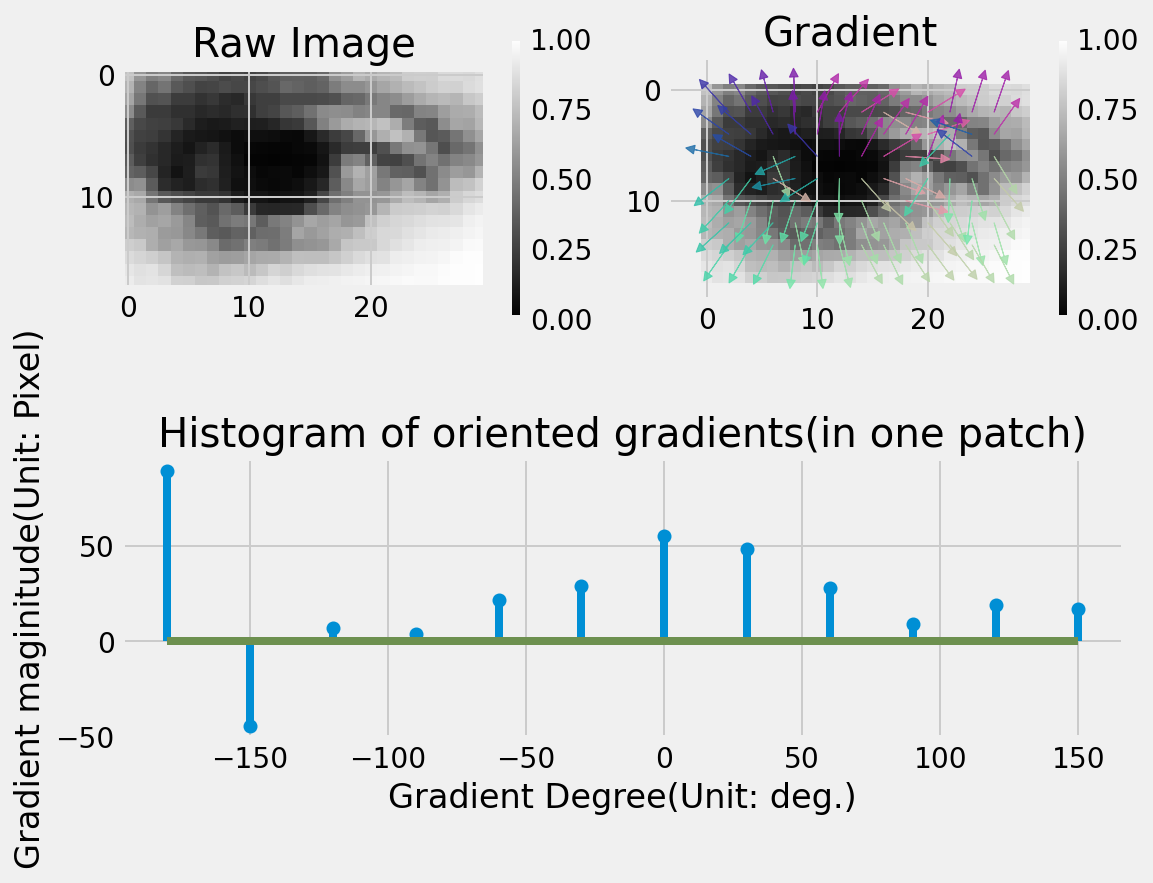

In [43]:
# visualize a random image
random_idx = random.randint(0, train_X.shape[0])
sample_im = train_X[random_idx]
grad_dir, grad_mag = compute_grad(sample_im)

hist = bilinear_HOG(grad_dir, grad_mag)

vis.vis_HOG(sample_im, grad_dir[0], grad_dir[1], hist)

### Descriptor blocks
To keep spatial information, in practice, HOG splits image into blocks to get histograms, then concatenate histograms in a fixed order(e.g: row major) to a vector.

<img src="figures/desc_block.png" style="zoom:60%" />

**Note**: In this section, we give the implementation of descriptor blocks based on your previous function of HOG. If you do not complete the bonus-3, maually modify `bilinear_HOG_DB` function to use non-vectorization version of HOG.
<br/><br/>

#### *Now, playground!*

- Run the following cell repeatedly and see what you get.

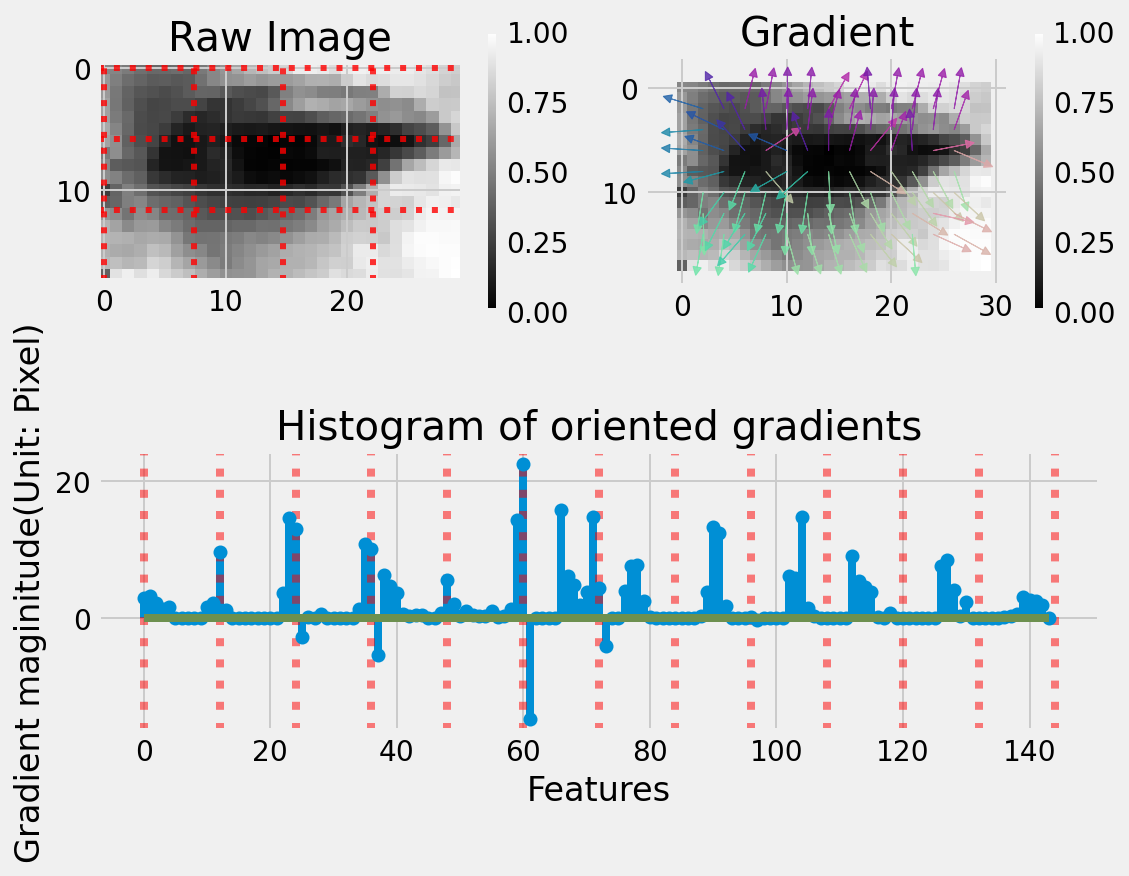

In [44]:
from AppearanceGazeEst import bilinear_HOG_DB

random_idx = random.randint(0, train_X.shape[0])
sample_im = train_X[random_idx]
grad_dir, grad_mag = compute_grad(sample_im)

# You can modify hyperparameter patch_num here, though not recommended
patch_num = (3, 4)
hist = bilinear_HOG_DB(sample_im, patch_num=patch_num)

vis.vis_HOG_full(sample_im, grad_dir[0], grad_dir[1], hist, patch_num=patch_num)

## Bonus-4 Combine HOG with K-NN (5 points)

At the previous sections, we applied HOG to a raw image to transform it into a vector. Let's apply HOG (completed in the previous notebook) to all images here.

Then, we could do KNN over the "HOGed" images. You would see the improvement of performance with respect to the previous section. Since our python-based implementation of HOG is inefficient, the estimation process may be a little bit long. 

![](figures/code_time.png)

**Complete the code of the HOG computation at `ApperanceGazeEstV2/KNN_HOG`**

[[ 6.66133815e-16 -6.10622664e-16  1.30882353e-01 ...  4.68911683e+00
   2.42647059e+00  0.00000000e+00]
 [ 1.12822341e+01 -6.41545117e+00  1.12957880e+00 ...  9.61152259e-01
   1.64803922e+00  0.00000000e+00]
 [ 2.98552280e+01 -1.79391069e+01  4.97976642e+00 ...  8.80718552e-01
   9.13235294e-01  0.00000000e+00]
 ...
 [ 3.52479746e+00  2.43005714e-01  1.24047431e+00 ...  1.23258819e+00
   1.45745600e+00  1.38934076e+00]
 [ 8.82264359e-01  1.64576312e+00  1.08566499e+00 ...  1.86951708e+00
   3.21194449e+00  4.06630547e-01]
 [ 2.12716827e+01 -1.46169191e+01  2.77328432e+00 ...  1.04966400e+00
   1.45882353e+00  0.00000000e+00]]
[ 0.1283756  -0.06597272]
Pass local test@Bonus-4 - eye images


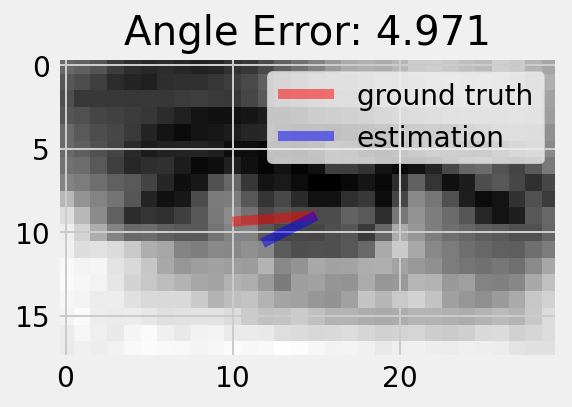

In [15]:
# Local Test - Eye images
# Note: feel free to print out your result to debug if it cannot pass assert_eq_np
from AppearanceGazeEst import KNN_HOG
from gazelib.task_2_judge import assert_eq_np
from gazelib.task_3_judge import compute_angle_error

idx = 10
# truncate the traininig set to improve the performance
ret = KNN_HOG(train_X, train_Y, val_X[idx], 5)
print(ret)
assert_eq_np(ret, np.array([0.1283756,  -0.06597272]))

print("Pass local test@Bonus-4 - eye images")
plt.figure(figsize=(4, 3))
vis.visualize_est(val_X[idx], ret, val_Y[idx])
plt.title("Angle Error: {:.3f}".format(compute_angle_error(val_Y[idx], ret)));

![](figures/good_job_banner.png)
You should have completed **all cells(35 points)** in this task locally when you reach here!

**CheckList**

- conv2d (10 points)
- compute_grad (10 points)
- bilinear_HOG (10 points)
- KNN_HOG (5 points)

## Reference

- [1] Intuitively Understanding Convolutions for Deep Learning: https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1
- [2] Image gradient wiki: https://en.wikipedia.org/wiki/Image_gradient
- [3] One of image gradient visualization is imported from: https://www.learnopencv.com/histogram-of-oriented-gradients/
- [4] https://en.wikipedia.org/wiki/Sobel_operator
- [5] https://www.learnopencv.com/histogram-of-oriented-gradients/
- [6] https://en.wikipedia.org/wiki/Atan2
- [7] https://www.geeksforgeeks.org/vectorization-in-python/